https://www.zybuluo.com/hanbingtao/note/476663（詳細理解誤差項δ的含義，以及在對各個權值求偏导时δ代表什么）
  
https://www.cnblogs.com/ssyfj/p/12820348.html(理論---吴恩达，结合了δ，求解得到Δ梯度值，W = W - lamda*Δ)
  
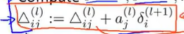
  
https://www.cnblogs.com/ssyfj/p/12846147.html（實踐）

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
import math

400 × 25 × 10 （不含偏执单元）
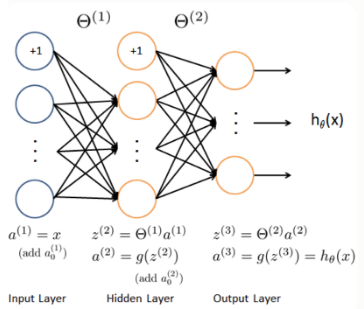

In [2]:
#加载数据
data = loadmat("ex4data1.mat")
X = data['X']
y = data['y']

In [20]:
#数据预处理，在神经网络中，我们的标签需要进行one_hot处理---也可以使用sklearn库函数
def one_hot(ylabels):
    yPred = np.full([y.shape[0],10],0) #我们将其他不正确的分类设置为0.1概率，正确的设置为0.9
    for i in range(y.shape[0]): # 1 2 3 4 5 6 7 8 9 10 这样的标签排列，其中10表示0,数据集是这么表示的，没办法
        yPred[i][y[i][0]-1] = 1
    return yPred

#随机初始化权值
def weightInit(layerNums_1,layerNums_2): 
    return np.random.normal(0,1,size=(layerNums_1,layerNums_2))

y_onehot = one_hot(y)

input_size = 400    #输入层
hidden_size = 25    #隐藏层
num_labels = 10     #输出层

#重点：我们需要将下一层的格式放在前面 （隐藏层，输入层）或者（输出层，隐藏层)------具体原因不知道（实验中会用到库scipy.optimize.minimize函数，发现这种比正向效果更好，可能是我们处理数据有问题），还是按照这种计算吧
theta1 = weightInit(hidden_size,input_size+1) #含一个偏执单元
theta2 = weightInit(num_labels,hidden_size+1) #含一个偏执单元

theta_param = np.concatenate([np.ravel(theta1),np.ravel(theta2)])
#print(theta1.shape)
#print(theta1)
#randidx = np.random.choice(y.shape[0],10)
#print(y[randidx])
#print(y_onehot[randidx,:])

In [4]:
#数据可视化
def displayData(X,ImageW=None,displayNums=100):
    if ImageW is None:
        ImageW = math.floor(math.sqrt(X.shape[1])) #之所以使用math,而不用np.是因为
    m,n = X.shape
    #获取图片高度
    ImageH = math.ceil(n/ImageW)
    #计算显示图片排列行列信息
    display_rows = math.floor(np.sqrt(displayNums))
    display_cols = math.ceil(displayNums//display_rows)
    #绘制绘图区域，开始显示图片#https://blog.csdn.net/qq_39622065/article/details/82909421
    fig,ax = plt.subplots(nrows=display_rows,ncols=display_cols,sharey=True,sharex=True,figsize=(12,12)) 
    
    #开始将子图像显示在各个子区域中
    for row in range(display_rows):
        for col in range(display_cols):
            ax[row,col].matshow(X[display_rows*row+col].reshape(ImageW,ImageH),cmap='gray') #显示灰度图像
    
    #设置不显示刻度
    plt.xticks([])
    plt.yticks([])
    plt.show()

#下面开始随机选取100张图片进行显示
#sample_idx = np.random.choice(range(X.shape[0]),100) #随机选取100个数据索引
#sample_imgs = X[sample_idx]
#displayData(sample_imgs)

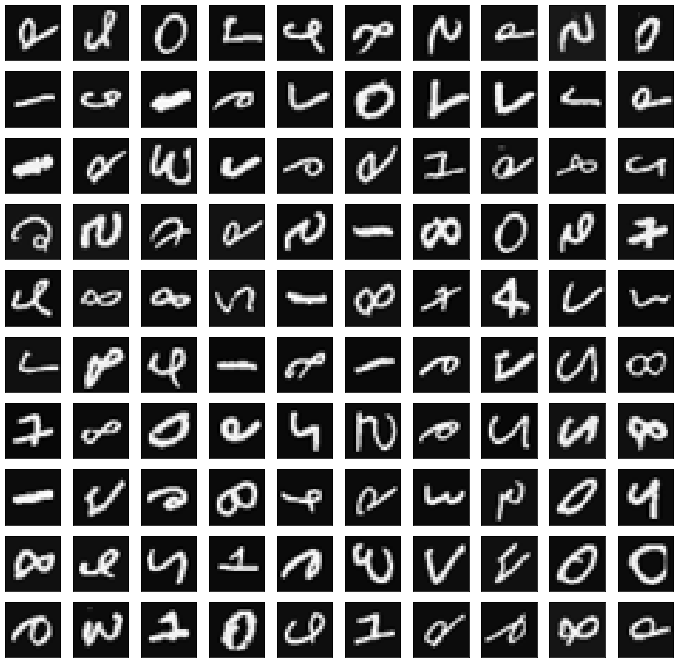

In [5]:
#实现sigmoid函数
def sigmoid(Z):
    return 1/(1+np.exp(-Z)) 

In [6]:
#实现前向传播
def forward_propagate(X,theta_1,theta_2):
    #对x添加偏执单元
    a1 = np.c_[np.ones([X.shape[0],1]),X] #(5000,401)
    #矩阵运算，求解隐藏层输入值，根据输入值求解激活值（输出值）
    z2 = a1@theta_1.T #（5000,401）×（401,25）
    a2 = sigmoid(z2)
    #中间隐藏层有偏置单元
    a2 = np.c_[np.ones([a2.shape[0],1]),a2]
    #同上，求解输出层
    z3 = a2@theta_2.T
    h = sigmoid(z3)
    return a1,z2,a2,z3,h #全部返回（反向传播可能用的上）

In [7]:
#实现代价函数（使用交叉熵，但是使用平方损失更容易理解，后面求解反向传播时会用平方损失来对比求解交叉熵的反向传播）
def cost(X,y,theta_1,theta_2,lamda=1):
    m = X.shape[0]
    #前向传播获取预测值h
    a1,z2,a2,z3,h = forward_propagate(X,theta_1,theta_2)
    #初始化代价值
    J = 0
    
    #根据下面的公式求解代价函数值（不含正则项）
    for i in range(m): #遍历每一个样本
#        first_term = np.multiply(-y[i,:],np.log(h[i,:]))
#        second_term = np.multiply((1-y[i,:]),np.log(1-h[i,:]))
#        J += np.sum(first_term-second_term)
        J += np.sum(1/2*(np.power(y[i,:]-h[i,:],2)))
    
    J /= m
    #加上正则项
    J += (lamda/(2*m))*(np.power(theta_1[:,1:],2).sum()+np.power(theta_2[:,1:],2).sum())
    
    return J

print(cost(X,y_onehot,theta1,theta2,1))

3.2763407662496107


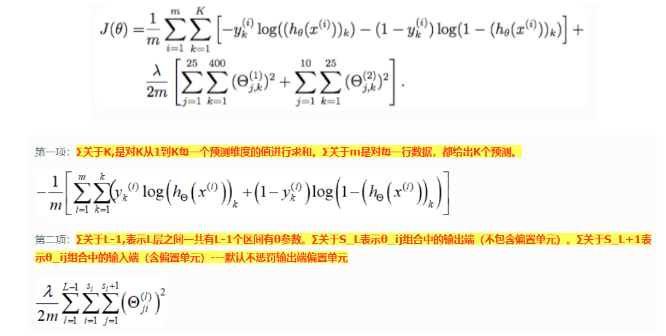

In [8]:
#下面进行反向传播
#各种函数求导：平方损失、交叉熵、多累分类https://zhuanlan.zhihu.com/p/99923080
#sigmoid求导
def sigmoid_gradient(output): #注意：这里我们在前向传播中获取了输出值，不需要再次计算
    return output*(1-output)

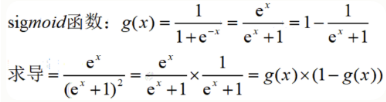

In [9]:
#交叉熵求导,传入标签值和预测值
def J_gradient(y,y_pred):
    return -y/y_pred+(1-y)/(1-y_pred)

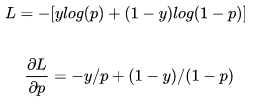

In [10]:
#反向传播实现（下面的截图全部来自下面两篇文章），截图看不懂，就看这两个文章吧，结合着来
#https://www.cnblogs.com/ssyfj/p/12820348.html无推导，代价求导有出入，但简洁）
#https://www.zybuluo.com/hanbingtao/note/476663（有推导，代价求导使用平方损失，但类似）
def backprop(theta_param,X,y,input_size,hidden_size,num_labels,lamda=1):
    m = X.shape[0]
    theta_1 = theta_param[:(input_size + 1) * hidden_size].reshape(hidden_size,(input_size + 1))
    theta_2 = theta_param[(input_size + 1) * hidden_size:].reshape(num_labels,(hidden_size + 1))

    J = cost(X,y,theta_1,theta_2,lamda)
    print(J)
    
    #实现反向传播
    delta1 = np.zeros(theta_1.shape)  #由神经网络图可以知道delta和theta转置是同型矩阵 theta_1  delta1（401,25）
    delta2 = np.zeros(theta_2.shape)  #theta_2（26,10）  delta_2 (10,26)
    
    #先获取前向传播的返回值（反向传播需要）
    a1,z2,a2,z3,h = forward_propagate(X,theta_1,theta_2)
    
    #实现反向传播
    for i in range(m):
        a1i = a1[i,:]   #获取a1中得第i个
        z2i = z2[i,:]   #是（1，25）矩阵
        a2i = a2[i,:]
        hi = h[i,:]
        yi = y[i,:]
        
        #获取输出层，第3层的误差delta3(向前求导)---这里是按平方损失来算的1/2（hi-yi)^2
        d3i = np.array([hi - yi]) #(1,10) 重点：d3i d2i与当前层的激活单元有关(含偏置单元），delta1,delta2与权值向量有关 
        #d3i = np.array([J_gradient(yi,hi)]) #为啥没有上面的效果好？？
        #再获取隐藏层的误差 重点：记得对输出值a2i进行sigmoid_gradient操作
        d2i = np.multiply(d3i@theta_2,sigmoid_gradient(a2i))  #d3i (1,10) theta2 (26,10) d3i@theta2 (1,26)
       
        #累加所有元素求解的误差 d2i (1,26) 但是delta1与theta1同型（401,25），所以我们不想要d2i中偏置单元信息
        delta1 = delta1 + (d2i[:,1:]).T*a1i #a1i就是传入隐藏层的输入值X（1,401） (d2i[:,1:]).T （1,25） (d2i[:,1:]).T*a1i=>(25,401)
        delta2 = delta2 + (d3i[:,:]).T*a2i #a2i就是传入隐藏层的输入值X（1,26）  (d3i[:,:]).T  (1,10)   (d3i[:,:]).T*a2i=>(10,26)  
        
    #首先用正向传播方法计算出每一层的激活单元，利用训练集的结果与神经网络预测的结果求出最后一层的误差，然后利用该误差运用反向传播法计算出直至第二层的所有误差。
    #按下面的推导，似乎到这里求解得到的delta1,delta2便是3个层之间的权值梯度，但是按照吴恩达所说，对于反向传播中，我们依旧需要进行正则化操作
    delta1 = delta1 / m
    delta2 = delta2 / m

    #加入正则化操作    注意：我们这里不包含δ_0
    delta1[:,1:] = delta1[:,1:] + (theta_1[:,1:]*lamda) / m
    delta2[:,1:] = delta2[:,1:] + (theta_2[:,1:]*lamda) / m
    
    grad = np.concatenate([np.ravel(delta1),np.ravel(delta2)])
    
    return J,grad #返回3层中间的两组权值梯度

In [11]:
#预测函数
def predict_new(theta_1,theta_2,X):
    X = np.insert(X,0,1,axis=1)    #插入一列全为1的列向量到X中
    h_1 = sigmoid(X@theta_1.T)
    h_1 = np.insert(h_1,0,1,axis=1)
    h_2 = sigmoid(h_1@theta_2.T)

    p = np.argmax(h_2,axis=1)+1
    return p

In [12]:
#注意：后面实现了我们自己的梯度下降算法，只不过效果没有这个好，这个用来对比和测试上面算法是否正确
#先使用库中最小化算法测试上面实现的所有算法---------------这么久了，开始测试一次以上算法实现是否正确
from scipy.optimize import minimize
fmin = minimize(fun=backprop,x0=theta_param,args=(X,y_onehot,input_size,hidden_size,num_labels,1e-3),method='TNC',jac=True,options={'maxiter':500})

theta_param_new = fmin.x
theta_1_new = theta_param_new[:(input_size + 1) * hidden_size].reshape(hidden_size,(input_size+1))
theta_2_new = theta_param_new[(input_size + 1) * hidden_size:].reshape(num_labels,(hidden_size + 1))

y_pred = predict_new(theta_1_new,theta_2_new,X)
correct = [1 if a==b else 0 for (a,b) in zip(y_pred,y)] #重点：将预测值和原始值进行对比
accuracy = (sum(map(int,correct))/float(len(correct)))  #找到预测正确的数据/所有数据==百分比
print('accuracy = {0}%'.format(accuracy*100 ))

2.2594621742755785
2.2594620499470115
2.259462163890833
2.2594618258435126
2.0236414549815835
1.2122143538565353
1.212213829853756
1.2122143384395583
0.8986700352649668
0.5101112995721279
0.5101112529393057
0.5101112976527518
0.5101112898216669
0.4899804967163113
0.9435684594443653
0.46255282077952997
0.4625527907510251
0.4625528152313849
0.4625528136289828
0.46255280437638113
0.4625527626178625
0.39424283823041506
0.4104023064055913
0.3897757374241443
0.38744606551488636
0.38744603787990595
0.3874460605835847
0.38744605891365735
0.38744606000115905
0.3874460514939728
0.2916363241822799
0.38421721096653777
0.2832422444454123
0.26000681351263066
0.26000680706812773
0.2600068107769909
0.2600068096903989
0.2600068101099201
0.2600068097960676
0.2600068076766536
0.2600067970773905
0.26000622915766614
0.19995690796179338
0.2982828243077751
0.22061849795666377
0.19675124942316508
0.19675123994022875
0.19675124605749075
0.19675124570708802
0.19675124079459178
0.19675122891158753
0.152932839304

0.005352235639243846
0.005352022347285412
0.005351934065001328
0.0053518944778285235
0.005351875818164234
0.005351866771244607
0.005351862318442124
0.005351860109696385
0.005351859009736289
0.005351858460859292
0.005351858186696533
0.005351858049684101
0.00535185798119511
0.005351857946954923
0.005351857929835905
0.005351857921276672
0.005351857916997119
0.005351857914857357
0.0053518579137874864
0.005351857913252546
0.00535185791298508
0.005351857769959026
0.006030554969972556
0.005502433103959861
0.005385903776403027
0.005358944481435205
0.005353153085225278
0.005351968657095335
0.005351781520163111
0.005351841877035107
0.005351803431751693
0.00535179041355566
0.0053517854517853986
0.00535178335727079
0.0053517824065491635
0.005351781955315201
0.005351781735729045
0.00535178162744357
0.005351781573677715
0.005351781546889003
0.0053517815335182
0.005351781526838694
0.005351781523500411
0.0053517815218316386
0.005351781520997344
0.0053517815205802195
0.0053517815203716615
0.00535178152

#前向传播和反向传播都使用平方损失时的效果更好
-----------
  
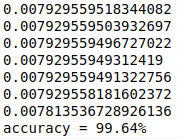
  
#问题一：如果前向传播使用交叉熵求解代价，使用平方损失求解反向传播，也可以获得不错的效果（但是会出现log溢出）
-----------
  
#问题二：如果前向传播和反向传播都使用交叉熵求解，结果效果反而不如平方损失的效果好，只能到达70%左右的效果....???
-----------

In [13]:
#开始实现梯度下降算法
def minimize(theta_param,X,y,input_size,hidden_size,num_labels,max_iter,lamda=1):
    for i in range(max_iter):
        J,grad = backprop(theta_param,X,y,input_size,hidden_size,num_labels,lamda)
        print(J)
        theta_param -= grad
    return theta_param

In [21]:
theta_param_new = minimize(theta_param,X,y_onehot,input_size,hidden_size,num_labels,max_iter=1500,lamda=1e-1)
theta_1_new = theta_param_new[:(input_size + 1) * hidden_size].reshape(hidden_size,(input_size+1))
theta_2_new = theta_param_new[(input_size + 1) * hidden_size:].reshape(num_labels,(hidden_size + 1))

y_pred = predict_new(theta_1_new,theta_2_new,X)
correct = [1 if a==b else 0 for (a,b) in zip(y_pred,y)] #重点：将预测值和原始值进行对比
accuracy = (sum(map(int,correct))/float(len(correct)))  #找到预测正确的数据/所有数据==百分比
print('accuracy = {0}%'.format(accuracy*100 ))

1.8484386969240665
1.8484386969240665
0.7177718897803625
0.7177718897803625
0.6298004903548271
0.6298004903548271
0.6131133926976677
0.6131133926976677
0.6006537512049084
0.6006537512049084
0.5891809432449412
0.5891809432449412
0.5781731803211532
0.5781731803211532
0.5675680869675099
0.5675680869675099
0.5573953727788808
0.5573953727788808
0.5477020771260053
0.5477020771260053
0.5385256338562368
0.5385256338562368
0.5298804842972903
0.5298804842972903
0.5217579643478147
0.5217579643478147
0.5141315536960747
0.5141315536960747
0.5069610746099332
0.5069610746099332
0.5001981746511395
0.5001981746511395
0.493793821438104
0.493793821438104
0.4877040216034469
0.4877040216034469
0.4818919175639589
0.4818919175639589
0.47632739948166963
0.47632739948166963
0.4709858479172166
0.4709858479172166
0.46584690999821915
0.46584690999821915
0.4608935725667912
0.4608935725667912
0.4561115046539127
0.4561115046539127
0.4514885767487524
0.4514885767487524
0.44701448398458105
0.44701448398458105
0.442680

0.23554253051745405
0.23519861723835908
0.23519861723835908
0.23485724533902289
0.23485724533902289
0.23451838139974104
0.23451838139974104
0.23418199249906785
0.23418199249906785
0.2338480462133467
0.2338480462133467
0.23351651061578527
0.23351651061578527
0.23318735427513787
0.23318735427513787
0.23286054625406402
0.23286054625406402
0.23253605610721095
0.23253605610721095
0.23221385387906962
0.23221385387906962
0.23189391010164312
0.23189391010164312
0.23157619579195582
0.23157619579195582
0.2312606824494285
0.2312606824494285
0.23094734205313036
0.23094734205313036
0.23063614705891805
0.23063614705891805
0.230327070396453
0.230327070396453
0.2300200854660966
0.2300200854660966
0.22971516613565646
0.22971516613565646
0.22941228673697509
0.22941228673697509
0.22911142206231938
0.22911142206231938
0.2288125473605611
0.2288125473605611
0.22851563833309704
0.22851563833309704
0.22822067112948669
0.22822067112948669
0.22792762234277572
0.22792762234277572
0.2276364690044651
0.22763646900

0.19333775965401737
0.19321562832919564
0.19321562832919564
0.19309396861625253
0.19309396861625253
0.19297277776402916
0.19297277776402916
0.1928520530334412
0.1928520530334412
0.19273179169747556
0.19273179169747556
0.1926119910411767
0.1926119910411767
0.1924926483616267
0.1924926483616267
0.19237376096791658
0.19237376096791658
0.19225532618111868
0.19225532618111868
0.1921373413342473
0.1921373413342473
0.1920198037722206
0.1920198037722206
0.19190271085181526
0.19190271085181526
0.19178605994162407
0.19178605994162407
0.1916698484220034
0.1916698484220034
0.19155407368503014
0.19155407368503014
0.19143873313444654
0.19143873313444654
0.1913238241856155
0.1913238241856155
0.1912093442654687
0.1912093442654687
0.19109529081246174
0.19109529081246174
0.19098166127652655
0.19098166127652655
0.19086845311902764
0.19086845311902764
0.19075566381272305
0.19075566381272305
0.19064329084172324
0.19064329084172324
0.1905313317014584
0.1905313317014584
0.19041978389864705
0.1904197838986470

0.17485164914714138
0.1747859801185228
0.1747859801185228
0.17472045820057092
0.17472045820057092
0.17465508281372016
0.17465508281372016
0.1745898533834463
0.1745898533834463
0.17452476934022
0.17452476934022
0.17445983011945743
0.17445983011945743
0.17439503516147387
0.17439503516147387
0.17433038391143593
0.17433038391143593
0.17426587581931605
0.17426587581931605
0.17420151033984654
0.17420151033984654
0.17413728693247316
0.17413728693247316
0.1740732050613124
0.1740732050613124
0.17400926419510593
0.17400926419510593
0.17394546380717557
0.17394546380717557
0.17388180337538242
0.17388180337538242
0.17381828238208158
0.17381828238208158
0.1737549003140808
0.1737549003140808
0.17369165666259737
0.17369165666259737
0.1736285509232166
0.1736285509232166
0.1735655825958497
0.1735655825958497
0.17350275118469283
0.17350275118469283
0.1734400561981863
0.1734400561981863
0.17337749714897266
0.17337749714897266
0.17331507355385728
0.17331507355385728
0.1732527849337677
0.1732527849337677
0.

0.16371625840079138
0.1636732540414589
0.1636732540414589
0.16363032923612444
0.16363032923612444
0.16358748374360607
0.16358748374360607
0.16354471732308826
0.16354471732308826
0.1635020297341253
0.1635020297341253
0.16345942073664774
0.16345942073664774
0.1634168900909668
0.1634168900909668
0.163374437557781
0.163374437557781
0.16333206289817853
0.16333206289817853
0.16328976587364555
0.16328976587364555
0.1632475462460687
0.1632475462460687
0.163205403777741
0.163205403777741
0.16316333823136642
0.16316333823136642
0.1631213493700654
0.1631213493700654
0.16307943695737837
0.16307943695737837
0.163037600757272
0.163037600757272
0.16299584053414107
0.16299584053414107
0.16295415605281718
0.16295415605281718
0.16291254707856945
0.16291254707856945
0.1628710133771107
0.1628710133771107
0.16282955471460175
0.16282955471460175
0.1627881708576549
0.1627881708576549
0.16274686157333923
0.16274686157333923
0.16270562662918378
0.16270562662918378
0.1626644657931818
0.1626644657931818
0.162623

0.15613550164146076
0.15610469130131396
0.15610469130131396
0.15607392263704864
0.15607392263704864
0.15604319553855045
0.15604319553855045
0.1560125098963441
0.1560125098963441
0.1559818656015931
0.1559818656015931
0.15595126254609457
0.15595126254609457
0.15592070062227678
0.15592070062227678
0.15589017972319658
0.15589017972319658
0.1558596997425355
0.1558596997425355
0.155829260574597
0.155829260574597
0.15579886211430288
0.15579886211430288
0.1557685042571896
0.1557685042571896
0.15573818689940663
0.15573818689940663
0.1557079099377101
0.1557079099377101
0.15567767326946308
0.15567767326946308
0.15564747679262939
0.15564747679262939
0.15561732040577134
0.15561732040577134
0.15558720400804515
0.15558720400804515
0.15555712749919964
0.15555712749919964
0.15552709077957022
0.15552709077957022
0.15549709375007637
0.15549709375007637
0.1554671363122193
0.1554671363122193
0.15543721836807564
0.15543721836807564
0.15540733982029575
0.15540733982029575
0.15537750057210015
0.15537750057210

0.15047445735067366
0.15045063237048786
0.15045063237048786
0.15042683431685577
0.15042683431685577
0.15040306313464147
0.15040306313464147
0.15037931876872115
0.15037931876872115
0.15035560116398466
0.15035560116398466
0.1503319102653343
0.1503319102653343
0.15030824601768653
0.15030824601768653
0.15028460836597024
0.15028460836597024
0.15026099725512898
0.15026099725512898
0.1502374126301192
0.1502374126301192
0.1502138544359126
0.1502138544359126
0.15019032261749418
0.15019032261749418
0.15016681711986496
0.15016681711986496
0.15014333788804052
0.15014333788804052
0.150119884867052
0.150119884867052
0.15009645800194726
0.15009645800194726
0.15007305723778963
0.15007305723778963
0.15004968251965994
0.15004968251965994
0.15002633379265634
0.15002633379265634
0.15000301100189517
0.15000301100189517
0.14997971409251115
0.14997971409251115
0.1499564430096573
0.1499564430096573
0.1499331976985076
0.1499331976985076
0.14990997810425544
0.14990997810425544
0.14988678417211526
0.149886784172

0.14600071337795026
0.1459813902150637
0.1459813902150637
0.14596208378266742
0.14596208378266742
0.14594279404245905
0.14594279404245905
0.1459235209562362
0.1459235209562362
0.14590426448589744
0.14590426448589744
0.14588502459343944
0.14588502459343944
0.1458658012409586
0.1458658012409586
0.14584659439064815
0.14584659439064815
0.1458274040047992
0.1458274040047992
0.1458082300457994
0.1458082300457994
0.14578907247613243
0.14578907247613243
0.14576993125837723
0.14576993125837723
0.1457508063552071
0.1457508063552071
0.14573169772938932
0.14573169772938932
0.14571260534378488
0.14571260534378488
0.14569352916134698
0.14569352916134698
0.14567446914512033
0.14567446914512033
0.1456554252582413
0.1456554252582413
0.14563639746393664
0.14563639746393664
0.14561738572552252
0.14561738572552252
0.14559839000640487
0.14559839000640487
0.1455794102700774
0.1455794102700774
0.14556044648012148
0.14556044648012148
0.14554149860020585
0.14554149860020585
0.1455225665940851
0.145522566594085

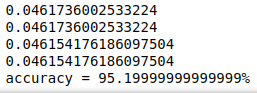